In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pmdarima import auto_arima

from utils import generate_data, diagnosis

# Use ggplot style
plt.style.use("ggplot")
np.random.seed(42)

## Data generation

In [2]:
data = generate_data()
data.head()

,y,detailing,seminar_lag1,email
2019-01-31,57.640314,8.764663,5.214174,8.129941
2019-02-28,59.743582,8.861736,5.214174,8.390911
2019-03-31,68.621196,10.647689,7.564644,7.381525
2019-04-30,65.109269,12.523030,4.130255,7.339772
2019-05-31,71.887811,11.497897,8.120941,8.260971


## Visualization of the time series

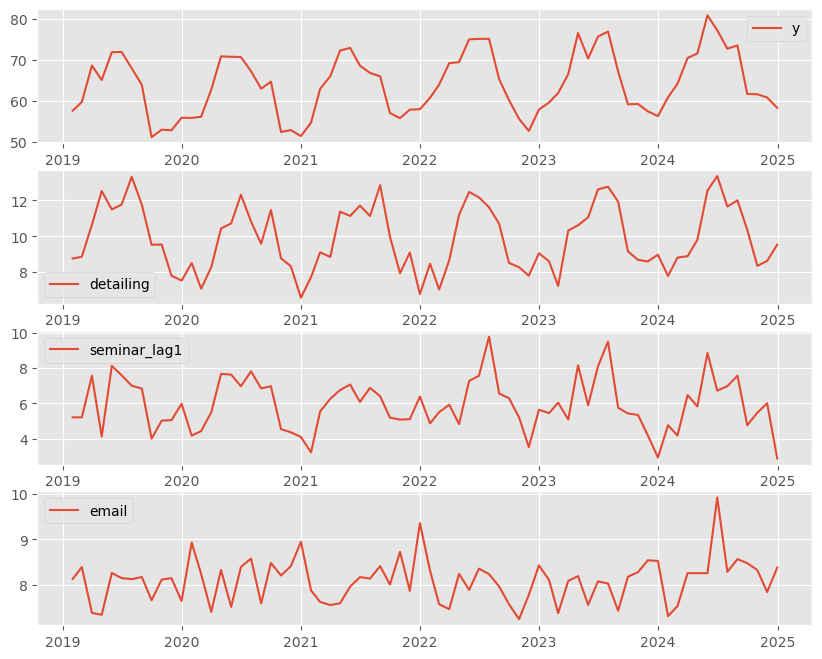

In [3]:
# Create a line plot for each data series
plt.figure(figsize=(10, 8))
num_cols = len(data.columns)
for i, col in enumerate(data.columns):
    plt.subplot(num_cols, 1, i + 1)
    plt.plot(data.index, data[col], label=col)
    plt.legend()
plt.show()

In [4]:
y = data["y"]
X = data[["detailing", "seminar_lag1", "email"]]

## Find a reasonable range of $(p, q)$ by ACF and PCF
Before we fit a regression model with $ARMA(p, q)$, we need to obtain a reasonable range of $p$ and $q$

In [5]:
ols = sm.OLS(y, sm.add_constant(X)).fit()
resid = ols.resid

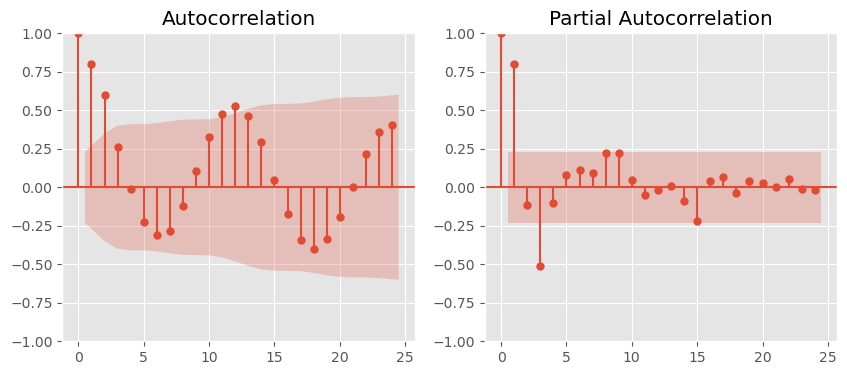

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(resid, lags=24, ax=axes[0])
plot_pacf(resid, lags=24, ax=axes[1])
plt.show()

## Option 1: Manual Inspection to find the best (p, q) and fit a model
We fine the best (p, q) by a grid search based on the AICC criterion
We then finalize a model with the lowest AICC

In [7]:
from itertools import product

best_aicc = np.inf
best_order = None
best_model = None
best_result = None
for p, q in product(range(3), range(3)):  # try 0,1,2
    model = SARIMAX(
        y,
        exog=data[["detailing", "seminar_lag1", "email"]],
        order=(p, 0, q),
        trend="c",
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)
    if res.aicc < best_aicc:
        best_aicc, best_order = res.aicc, (p, q)
        best_model = model
        best_result = res
    print(f"(p,q)=({p},{q})  AICC={res.aicc:.2f}")
print("Best order:", best_order)

(p,q)=(0,0)  AICC=395.49
(p,q)=(0,1)  AICC=341.74
(p,q)=(0,2)  AICC=300.83
(p,q)=(1,0)  AICC=312.63
(p,q)=(1,1)  AICC=304.12
(p,q)=(1,2)  AICC=288.82
(p,q)=(2,0)  AICC=293.13
(p,q)=(2,1)  AICC=290.80
(p,q)=(2,2)  AICC=274.16
Best order: (2, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

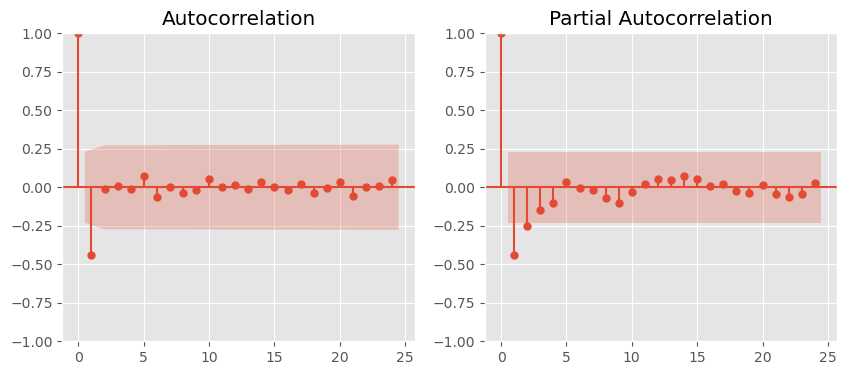

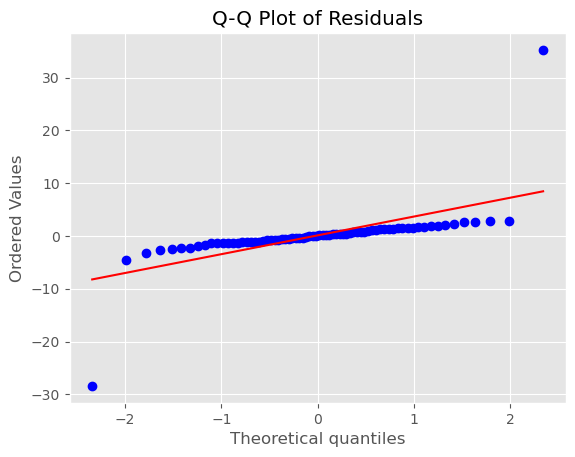

      lb_stat  lb_pvalue
12  15.813814   0.199913


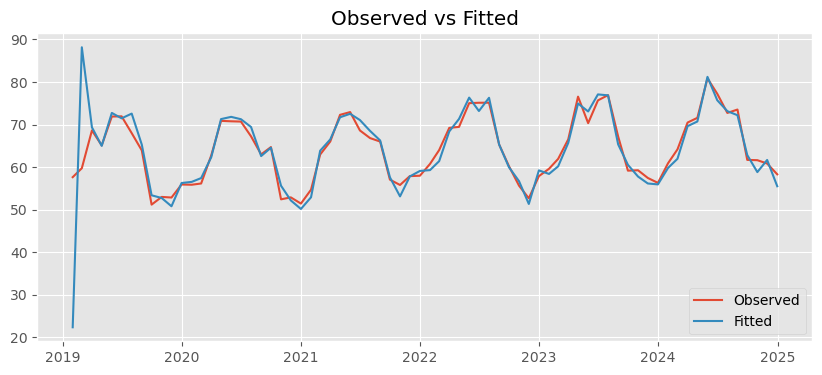

In [8]:
diagnosis(best_result, data)

## Option 2: AutoARIMA
We can also use `auto_arima` to autoamtically find the best $(p, q)$

In [9]:
# (1) Find the best (p, q)
auto = auto_arima(
    y,
    exogenous=X,
    d=0,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    seasonal=False,
    information_criterion="aicc",
    stepwise=False,
    suppress_warnings=True,
)

# Best orders chosen by the search:
print("Selected order (p,d,q):", auto.order)  # e.g., (1, 0, 1)
print("Selected seasonal order (P,D,Q,m):", auto.seasonal_order)  # (0,0,0,0) here

Selected order (p,d,q): (1, 0, 3)
Selected seasonal order (P,D,Q,m): (0, 0, 0, 0)


In [10]:
# 2) Extract orders
(p, d, q) = auto.order
(P, D, Q, m) = auto.seasonal_order  # will be (0,0,0,0) if seasonal=False

# 3) Refit with SARIMAX using the selected orders
#    (trend='c' adds an intercept; set to 'n' if you don’t want one)
model = SARIMAX(
    y,
    exog=X,
    order=(p, 0, q),  # note: d=0 because we’re modeling level with ARMA errors
    seasonal_order=(P, D, Q, m),  # (0,0,0,0) for non-seasonal search above
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
)
auto_result = model.fit(disp=False)

# 4) Standard statsmodels summary
print(auto_result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -132.083
Date:                Wed, 08 Oct 2025   AIC                            282.165
Time:                        11:56:49   BIC                            302.141
Sample:                    01-31-2019   HQIC                           290.080
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       13.2975      6.617      2.010      0.044       0.328      26.267
detailing        1.5406      0.156      9.875      0.000       1.235       1.846
seminar_lag1     2.2028      0.153     14.37

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


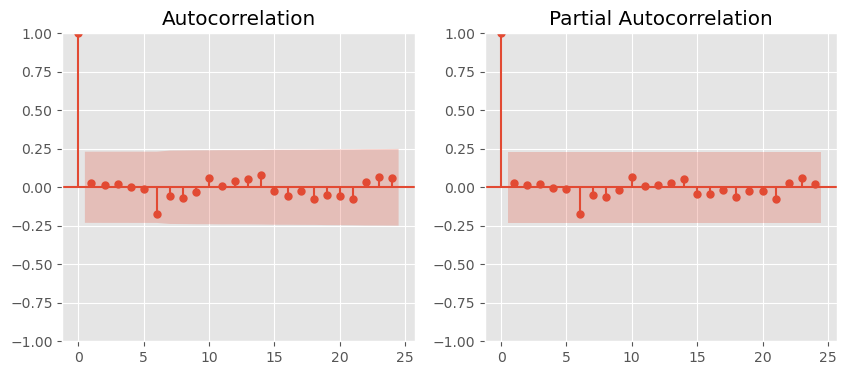

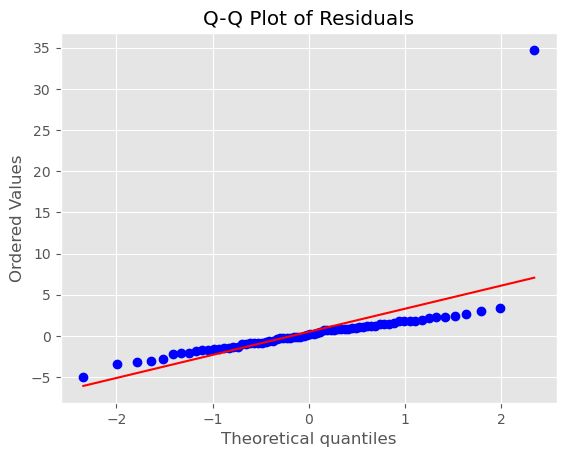

     lb_stat  lb_pvalue
12  3.730164   0.987828


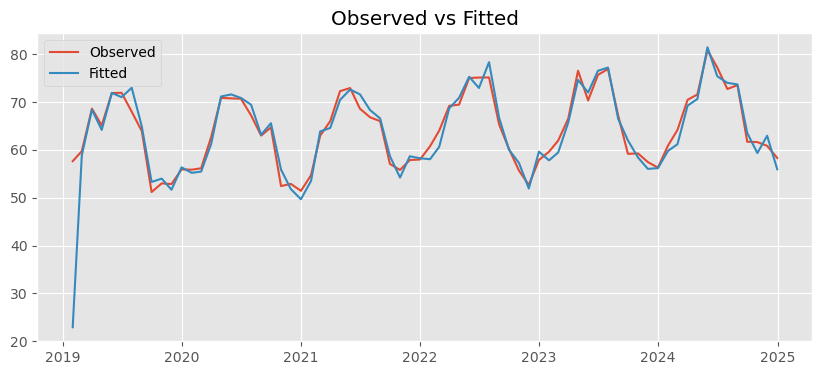

In [11]:
diagnosis(auto_result, data)